In [1]:
from dataclasses import dataclass, asdict
from typing import Union, Optional, Literal, Tuple
import os
from pathlib import Path
import json
import tyro
import copy
from tqdm.auto import tqdm

import numpy as np
import torch
import torch.utils.checkpoint

from torch.utils.tensorboard import SummaryWriter

from accelerate.utils import set_seed
from accelerate.logging import get_logger
from diffusers import DPMSolverMultistepScheduler, UniPCMultistepScheduler, DDPMScheduler, DDIMScheduler

from model.custom_unet_2d_condition import (
    UNet2DConditionCrossFrameInExistingAttnModel,
)
from model.util import (
    replace_self_attention_with_cross_frame_attention,
    add_pose_cond_to_attention_layers,
    update_cross_frame_attention_config,
    update_last_layer_mode,
    update_vol_rend_inject_noise_sigma,
    update_n_novel_images,
    CrossFrameAttentionConfig,
    ModelConfig,
)
from model.custom_stable_diffusion_pipeline import CustomStableDiffusionPipeline
from model.custom_stable_instructPix2pix_pipeline import CustomInstructPix2pixDiffusionPipeline

from io_util import (
    setup_output_directories,
    make_output_directories,
    convert_to_tensorboard_dict,
    SaveConfig
)

from metrics.image_metrics import load_lpips_vgg_model

from model.util import (
    replace_self_attention_with_cross_frame_attention,
    update_last_layer_mode,
    update_vol_rend_inject_noise_sigma,
    update_n_novel_images,
    update_cross_frame_attention_config,
    add_pose_cond_to_attention_layers,
    collapse_prompt_to_batch_dim,
    collapse_tensor_to_batch_dim,
    expand_output_to_k,
    expand_tensor_to_k,
    tokenize_captions,
    ModelConfig,
    CrossFrameAttentionConfig,
    build_cross_attention_kwargs,
)



from train_util import FinetuneConfig
from diffusers.loaders import LoraLoaderMixin

from dacite import from_dict, Config

from train import test_step

logger = get_logger(__name__, log_level="INFO")

/root/autodl-tmp/ViewDiff/viewdiff
/root/autodl-tmp/ViewDiff/viewdiff
/root/autodl-tmp/ViewDiff/viewdiff
/root/autodl-tmp/ViewDiff/viewdiff


In [2]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [3]:
class dataconfig:
    root_dir ="/root/autodl-tmp/mvs_training/dtu/"
    split = "val"

    target_light = 6
    n_views:int=3 
    levels:int=3 
    depth_interval:int =2.65
    img_wh:int=None
    abs_error:Optional[str] ="abs"
    output_total:Optional[bool]=False
    threshold: Optional[int] = 4.7
    prompt_dir: Optional[str] = "/root/autodl-tmp/mvs_training/dtu/co3d_blip2_captions_final.json"


In [4]:
from torch.utils.data import Dataset
import sys
sys.path.append('/root/autodl-tmp/project/dp_simple/')
from CasMVSNet_pl.datasets.utils import read_pfm
import os
import numpy as np
import cv2
from PIL import Image
import torch
from torchvision import transforms as T
class DTUDataset(Dataset):
    def __init__(self, config):
        """
        img_wh should be set to a tuple ex: (1152, 864) to enable test mode!
        """

        self.root_dir = config.root_dir
        self.split = config.split
        assert self.split in ['train', 'val', 'test'], \
            'split must be either "train", "val" or "test"!'
        
        
        self.light_class = config.target_light
        self.img_wh = None

        
        self.threshold = config.threshold
        self.build_metas()
        self.n_views = config.n_views
        self.levels = config.levels # FPN levels
        self.depth_interval = config.depth_interval
        self.build_proj_mats()
        self.define_transforms()
        self.output_total = config.output_total
        prompt_dir = config.prompt_dir
        if prompt_dir != None:
            import json
            captions = json.load(open(prompt_dir))
        self.prompt_dir =captions
        
      
        
        
        
    def build_metas(self):
        self.metas = []
        with open(f'/root/autodl-tmp/project/dp_simple/CasMVSNet_pl/datasets/lists/dtu/{self.split}.txt') as f:
            self.scans = [line.rstrip() for line in f.readlines()]
        output_pkl = f'/root/autodl-tmp/project/dp_simple/CasMVSNet_pl/datasets/lists/dtu/{self.split}_abs.pkl'
        import pickle
        with open(output_pkl, 'rb') as f:
            self.output_pkl = pickle.load(f)
        # light conditions 0-6 for training
        # light condition 3 for testing (the brightest?)
        outputs_total = {}
        for scan in self.output_pkl.keys():
            scan_index = scan.split('_')[0]
            if scan_index not in outputs_total:
                outputs_total[scan_index] = []
            outputs_total[scan_index].append(self.output_pkl[scan])
        for scan in outputs_total.keys():
            outputs_total[scan] = np.mean(np.array(outputs_total[scan]), axis=0)
            print(f"scan {scan} mean output: {outputs_total[scan]}")
        self.total_pkl = outputs_total


        light_idxs = list(range(7))

        pair_file = "Cameras/pair.txt"
        for scan in self.scans:
            with open(os.path.join(self.root_dir, pair_file)) as f:
                num_viewpoint = int(f.readline())
                # viewpoints (49)
                for _ in range(num_viewpoint):
                    ref_view = int(f.readline().rstrip())
                    src_views = [int(x) for x in f.readline().rstrip().split()[1::2]]
                    

                    for light_idx in light_idxs:
                        output_key = f"{scan}_{ref_view}_{src_views[0]}_{src_views[1]}"
                        losses = self.output_pkl[output_key]
                        if np.argmin(losses)==self.light_class and self.split=="train":
                            self.metas += [(scan, ref_view,light_idx, src_views,int(np.argmin(losses)))]
                        elif self.split!="train":
                            if light_idx!=0:
                                continue
                            else:
                                self.metas += [(scan, ref_view,light_idx, src_views,int(np.argmin(losses)))]
                                
                                
                           
                         
    def build_proj_mats(self):
        proj_mats = []
        for vid in range(49): # total 49 view ids
            if self.img_wh is None:
                proj_mat_filename = os.path.join(self.root_dir,
                                                 f'Cameras/train/{vid:08d}_cam.txt')
            else:
                proj_mat_filename = os.path.join(self.root_dir,
                                                 f'Cameras/{vid:08d}_cam.txt')
            intrinsics, extrinsics, depth_min = \
                self.read_cam_file(proj_mat_filename)
            if self.img_wh is not None: # resize the intrinsics to the coarsest level
                intrinsics[0] *= self.img_wh[0]/1600/4
                intrinsics[1] *= self.img_wh[1]/1200/4
            K = intrinsics
            R = extrinsics
            # multiply intrinsics and extrinsics to get projection matrix
            proj_mat_ls = []
            for l in reversed(range(self.levels)):
                proj_mat_l = np.eye(4)
                proj_mat_l[:3, :4] = intrinsics @ extrinsics[:3, :4]
                intrinsics[:2] *= 2 # 1/4->1/2->1
                proj_mat_ls += [torch.FloatTensor(proj_mat_l)]
            # (self.levels, 4, 4) from fine to coarse
            proj_mat_ls = torch.stack(proj_mat_ls[::-1])
           
            proj_mats += [(proj_mat_ls, depth_min,K,R)]

        self.proj_mats = proj_mats

    def read_cam_file(self, filename):
        with open(filename) as f:
            lines = [line.rstrip() for line in f.readlines()]
        # extrinsics: line [1,5), 4x4 matrix
        extrinsics = np.fromstring(' '.join(lines[1:5]), dtype=np.float32, sep=' ')
        extrinsics = extrinsics.reshape((4, 4))
        # intrinsics: line [7-10), 3x3 matrix
        intrinsics = np.fromstring(' '.join(lines[7:10]), dtype=np.float32, sep=' ')
        intrinsics = intrinsics.reshape((3, 3))
        # depth_min & depth_interval: line 11
        depth_min = float(lines[11].split()[0])
        return intrinsics, extrinsics, depth_min

    def read_depth(self, filename):
        depth = np.array(read_pfm(filename)[0], dtype=np.float32) # (1200, 1600)
        if self.img_wh is None:
            depth = cv2.resize(depth, None, fx=0.5, fy=0.5,
                            interpolation=cv2.INTER_NEAREST) # (600, 800)
            depth_0 = depth[44:556, 80:720] # (512, 640)
        else:
            depth_0 = cv2.resize(depth, self.img_wh,
                                 interpolation=cv2.INTER_NEAREST)
        depth_1 = cv2.resize(depth_0, None, fx=0.5, fy=0.5,
                             interpolation=cv2.INTER_NEAREST)
        depth_2 = cv2.resize(depth_1, None, fx=0.5, fy=0.5,
                             interpolation=cv2.INTER_NEAREST)

        depths = {"level_0": torch.FloatTensor(depth_0),
                  "level_1": torch.FloatTensor(depth_1),
                  "level_2": torch.FloatTensor(depth_2)}
        
        return depths

    def read_mask(self, filename):
        mask = cv2.imread(filename, 0) # (1200, 1600)
       
        if self.img_wh is None:
            mask = cv2.resize(mask, None, fx=0.5, fy=0.5,
                            interpolation=cv2.INTER_NEAREST) # (600, 800)
            mask_0 = mask[44:556, 80:720] # (512, 640)
        else:
            mask_0 = cv2.resize(mask, self.img_wh,
                                interpolation=cv2.INTER_NEAREST)
        mask_1 = cv2.resize(mask_0, None, fx=0.5, fy=0.5,
                            interpolation=cv2.INTER_NEAREST)
        mask_2 = cv2.resize(mask_1, None, fx=0.5, fy=0.5,
                            interpolation=cv2.INTER_NEAREST)

        masks = {"level_0": torch.BoolTensor(mask_0),
                 "level_1": torch.BoolTensor(mask_1),
                 "level_2": torch.BoolTensor(mask_2)}

        return masks

    def define_transforms(self):
        if self.split == 'train': # you can add augmentation here
            self.transform = T.Compose([T.ToTensor(),
                                        T.Normalize(mean=[0.485, 0.456, 0.406], 
                                                    std=[0.229, 0.224, 0.225]),
                                       ])
        else:
            self.transform = T.Compose([T.ToTensor(),
                                        T.Normalize(mean=[0.485, 0.456, 0.406], 
                                                    std=[0.229, 0.224, 0.225]),
                                       ])
        self.unpreprocess = T.Compose([
            T.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
            T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        ])
    
    def decode_batch(self, batch):
        imgs = batch['imgs']
        proj_mats = batch['proj_mats']
        depths = batch['depths']
        masks = batch['masks']
        init_depth_min = batch['init_depth_min']
        depth_interval = batch['depth_interval']
        return imgs, proj_mats, depths, masks, init_depth_min, depth_interval

    def __len__(self):
        return len(self.metas)


    


    def  __getitem__(self, idx):
       
        scan, ref_view,light_idx, src_views,target_light = self.metas[idx]
        # use only the reference view and first nviews-1 source views
        view_ids = [ref_view] + src_views[:self.n_views-1]

        # output_key = f"{scan}_{ref_view}_{src_views[0]}_{src_views[1]}"
        # if self.total_pkl:
        #     target_light = self.total_pkl[scan]
        #     target_light = np.argmin(target_light)
        # else:
        #     target_light = self.output_pkl[output_key]
        #     target_light = np.argmin(target_light)

        

        sample = {}
        imgs = []
        cams = []
        proj_mats = []
        target_imgs = []
        Ks = []
        Rs = []
        intensity_stats =[]
        prompt = str(np.random.choice(self.prompt_dir[scan][str(ref_view)],1)[0])
         
        sample['prompt'] = [f"modify the lightness of image to light_class_{self.light_class} style"]
        for i, vid in enumerate(view_ids):
        # NOTE that the id in image file names is from 1 to 49 (not 0~48)
        
            img_filename = os.path.join(self.root_dir,
                            f'Rectified/{scan}_train/rect_{vid+1:03d}_{light_idx}_r5000.png')
            target_filename = os.path.join(self.root_dir,
                            f'Rectified/{scan}_train/rect_{vid+1:03d}_{self.light_class}_r5000.png')
            mask_filename = os.path.join(self.root_dir,
                            f'Depths/{scan}/depth_visual_{vid:04d}.png')
            depth_filename = os.path.join(self.root_dir,
                            f'Depths/{scan}/depth_map_{vid:04d}.pfm')
    

            img = Image.open(img_filename)
            target_img = Image.open(target_filename)
            if self.img_wh is not None:
                img = img.resize(self.img_wh, Image.BILINEAR)
                target_img = target_img.resize(self.img_wh, Image.BILINEAR)

            img = self.transform(img)
            target_img = self.transform(target_img)
            imgs += [img]
            target_imgs += [target_img]

            proj_mat_ls, depth_min,K,R = self.proj_mats[vid]
            Ks += [K]
            Rs += [R]
        



            if i == 0:  # reference view
                
                sample['init_depth_min'] = torch.FloatTensor([depth_min])
                
                sample['masks'] = self.read_mask(mask_filename)
                for key in sample['masks']:
                    sample['masks'][key] = sample['masks'][key]
                sample['depths'] = self.read_depth(depth_filename)
                for key in sample['depths']:
                    sample['depths'][key] = sample['depths'][key]
                sample["depth"] = sample["depths"]["level_0"]
                ref_proj_inv = torch.inverse(proj_mat_ls)
            else:
                
                proj_mats += [proj_mat_ls @ ref_proj_inv]
            var, mean = torch.var_mean(img)
            intensity_stat = torch.stack([mean, var], dim=0)
            intensity_stats.append(intensity_stat)
    
    
        imgs = torch.stack(imgs) # (V, 3, H, W)
        target_imgs = torch.stack(target_imgs)
        proj_mats = torch.stack(proj_mats)[:,:,:3] # (V-1, self.levels, 3, 4) from fine to coarse
        
        imgs = self.unpreprocess(imgs)
        target_imgs = self.unpreprocess(target_imgs)
       
        Ks = np.stack(Ks)
        Rs = np.stack(Rs)
        sample['pose'] = torch.tensor(Rs)
        sample['K'] = torch.tensor(Ks)
        sample['images'] = imgs
        sample["intensity_stats"] = torch.stack(intensity_stats)
        sample['proj_mats'] = proj_mats
        sample['depth_interval'] = torch.FloatTensor([self.depth_interval])
        sample['scan_vid'] = (scan, ref_view)
        

        sample['target_imgs'] = target_imgs
        sample["bbox"] =torch.tensor([[-1, -1, -1], [1, 1, 1]], dtype=torch.float32)



        return sample







In [5]:
val_data = DTUDataset(dataconfig)

scan scan3 mean output: [3.05263341 2.92222905 2.79727794 2.86347311 2.84872966 2.86011306
 2.89029897]
scan scan5 mean output: [1.27925969 1.21662743 1.19024779 1.17714057 1.17585228 1.13693983
 1.13944231]
scan scan17 mean output: [4.23918102 4.3646479  4.26873698 4.152941   4.16164234 4.44407791
 4.15546879]
scan scan21 mean output: [6.7044504  6.78296111 6.79752936 6.78882487 6.74292021 6.64370545
 6.71224226]
scan scan28 mean output: [8.33500304 8.26974845 8.08564879 7.80853114 7.63656337 7.53135754
 7.33638762]
scan scan35 mean output: [1.18667069 1.32775589 1.20760566 1.06743625 1.15983699 0.91010288
 0.87788923]
scan scan37 mean output: [21.1885944  21.17826699 21.25191359 21.18731575 20.97766127 20.14655309
 19.91200681]
scan scan38 mean output: [1.69360119 1.60652492 1.57134287 1.54112932 1.56236016 1.63116413
 1.62020702]
scan scan40 mean output: [3.64535844 3.69948315 3.71793726 3.69029421 3.68635351 3.71370282
 3.58273512]
scan scan43 mean output: [2.2589177  2.24700747 2.

In [6]:
class runfig:
    pretrained_model_name_or_path = "/root/autodl-tmp/ViewDiff/output_var_second/all/subset_all/input_3/train/class6/saved_model_from_checkpoint-15000/"
    n_input_images =3
    n_output_noise =3

In [7]:
config_path = config_path = os.path.join(runfig.pretrained_model_name_or_path, "config.json")
if not os.path.isfile(str(config_path)):
        raise ValueError("cannot find config.json in ", config_path)
with open(config_path, "r") as f:
    config_data = json.load(f)
finetune_config = from_dict(FinetuneConfig, data=config_data, config=Config(cast=[tuple, int]))
runfig.cross_frame_attention = finetune_config.cross_frame_attention
runfig.model = finetune_config.model


In [8]:
pipeline = CustomInstructPix2pixDiffusionPipeline.from_pretrained(
        runfig.pretrained_model_name_or_path
    )
pipeline.scheduler.config.prediction_type = finetune_config.training.noise_prediction_type

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Some weights of the model checkpoint were not used when initializing UNet2DConditionCrossFrameInExistingAttnModel: 
 ['down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.temb_proj.0.bias, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.temb_proj.0.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.temb_proj.2.bias, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.temb_proj.2.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_k_lora.down.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_k_lora.up.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_out_lora.down.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_out_lora.up.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_q_lora.down.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor.to_q_lora.up.weight, down_blocks.0.attentions.0.tr

In [9]:
replace_self_attention_with_cross_frame_attention(
                unet=pipeline.unet,
                n_input_images=runfig.n_input_images,
                to_k_other_frames=runfig.cross_frame_attention.to_k_other_frames,
                with_self_attention=runfig.cross_frame_attention.with_self_attention,
                random_others=runfig.cross_frame_attention.random_others,
                use_lora_in_cfa="cfa" in runfig.model.pose_cond_mode or "sa" in runfig.model.pose_cond_mode,
                use_temb_in_lora=runfig.cross_frame_attention.use_temb_cond,
                temb_out_size=8,
                pose_cond_dim=runfig.model.pose_cond_dim,
                rank=runfig.model.pose_cond_lora_rank,
            )

({},
 [Parameter containing:
  tensor([[ 0.0177, -0.0095, -0.0216,  ..., -0.0175, -0.0199,  0.0268],
          [-0.0217,  0.0184,  0.0176,  ..., -0.0135,  0.0031,  0.0075],
          [ 0.0210, -0.0158,  0.0262,  ...,  0.0007, -0.0117,  0.0089],
          ...,
          [ 0.0156, -0.0142, -0.0262,  ...,  0.0010,  0.0041, -0.0245],
          [ 0.0146, -0.0120, -0.0042,  ..., -0.0257, -0.0218,  0.0032],
          [ 0.0181,  0.0035,  0.0158,  ..., -0.0217, -0.0159, -0.0202]],
         requires_grad=True),
  Parameter containing:
  tensor([ 1.5986e-02,  2.6454e-02, -2.0904e-02,  1.5807e-02, -1.5979e-02,
          -2.1216e-02, -1.1049e-02, -9.8525e-03, -6.9384e-03, -2.5878e-02,
           3.0611e-03, -1.3414e-03, -2.2567e-02, -1.9804e-02,  6.3573e-03,
          -2.5674e-02, -6.5668e-03, -2.1744e-02, -2.5079e-02,  1.3924e-02,
          -9.3725e-03, -1.5163e-02, -8.7193e-03, -2.9962e-03,  8.7849e-03,
          -5.4743e-03, -3.8408e-03, -1.9797e-02, -2.1266e-02,  5.0162e-03,
          -2.6852e-

In [10]:
runfig.cross_frame_attention.last_layer_mode,finetune_config.training.changed_cfa_last_layer

('zero-conv', 'no_residual_connection')

In [11]:
runfig.cross_frame_attention.with_self_attention,runfig.cross_frame_attention.random_others,

(True, True)

In [12]:
def update_cfa_config(
   
    pipeline: CustomInstructPix2pixDiffusionPipeline,
):
    if runfig.cross_frame_attention.mode == "add_in_existing_block":
        update_cross_frame_attention_config(
            pipeline.unet,
            runfig.n_input_images,
            runfig.cross_frame_attention.to_k_other_frames,
            runfig.cross_frame_attention.with_self_attention,
            runfig.cross_frame_attention.random_others,
            change_self_attention_layers=False,  # should have custom cfa layers
        )
    elif runfig.cross_frame_attention.mode == "pretrained":
        update_cross_frame_attention_config(
            pipeline.unet,
            3,
            2,
            runfig.cross_frame_attention.with_self_attention,
            runfig.cross_frame_attention.random_others,
            change_self_attention_layers=True,  # should have cfa is sa layers
        )
    else:
        raise NotImplementedError(
            f"did not implement different n_input_images for cfa.mode={runfig.cross_frame_attention.mode}"
        )

In [13]:
if finetune_config.training.changed_cfa_last_layer != runfig.cross_frame_attention.last_layer_mode:
        print("Change last-layer-mode to", finetune_config.training.changed_cfa_last_layer)
        update_last_layer_mode(
            pipeline.unet,
            finetune_config.training.changed_cfa_last_layer,
        )
update_vol_rend_inject_noise_sigma(
        pipeline.unet, 0.0
    )
    # disable n_novel_images
update_n_novel_images(
        pipeline.unet, 0

    )
update_cfa_config(pipeline)

Change last-layer-mode to no_residual_connection


In [14]:
if runfig.model.pose_cond_mode != "none":
        # Set correct lora layers
        unet_lora_attn_procs, unet_lora_parameters = add_pose_cond_to_attention_layers(
            pipeline.unet,
            rank=runfig.model.pose_cond_lora_rank,
            pose_cond_dim=runfig.model.pose_cond_dim,
            only_cross_attention="sa" not in runfig.model.pose_cond_mode,
        )

        if unet_lora_parameters is not None:
            in_dir = os.path.join(runfig.pretrained_model_name_or_path, "unet")
            try:
                lora_state_dict, network_alpha = LoraLoaderMixin.lora_state_dict(in_dir, weight_name="pytorch_lora_weights.safetensors")
            except:
                lora_state_dict, network_alpha = LoraLoaderMixin.lora_state_dict(in_dir, weight_name="pytorch_lora_weights.bin")
            lora_state_dict = {k.replace("unet.", ""): v for k, v in lora_state_dict.items()}
            pipeline.unet.load_state_dict(lora_state_dict, strict=False)
            print("Loaded LoRA weights into model")

Loaded LoRA weights into model


In [15]:
pipeline = pipeline.to("cuda")

In [16]:
runfig.model.pose_cond_mode

'sa-ca'

In [17]:
import torch
@torch.no_grad()
def process_batch(
    
   
    pipeline,
   
    batch,
    guidance_scale=16,
    image_guidance_scale: float = 1.0,
    
):
    
    model_config=runfig.model
    cfa_config=runfig.cross_frame_attention
    io_config=runfig
    orig_hw=(512, 640)
    num_inference_steps=50
    n_repeat_generation=1
    generator = torch.Generator("cuda").manual_seed(42)

    # combine
    
    batch["images"] = batch["images"].to("cuda").unsqueeze(0)
    batch["target_imgs"] = batch["target_imgs"].to("cuda").unsqueeze(0) 
    batch["pose"] = batch["pose"].to("cuda").unsqueeze(0)
    batch["K"] = batch["K"].to("cuda").unsqueeze(0)
    batch["intensity_stats"] = batch["intensity_stats"].to("cuda").unsqueeze(0)
    batch["bbox"] = batch["bbox"].to("cuda").unsqueeze(0)

    # check if need to change n_input_images
    if runfig.n_input_images != batch["pose"].shape[1]:
        runfig.n_input_images = batch["pose"].shape[1]
        runfig.cross_frame_attention.to_k_other_frames = batch["pose"].shape[1] - 1
        runfig.model.n_input_images = batch["pose"].shape[1]
        update_cfa_config(runfig, pipeline)

    # alwasy set to 0
    batch["intensity_stats"] *= 0

    # create images
    batch_size = len(batch["prompt"])

    batch["images"] = 2*batch["images"]-1
    batch["target_imgs"] = 2*batch["target_imgs"]-1
    # parse batch
    # collapse K dimension into batch dimension (no concatenation happening)
    batch["prompt"] = [cap for cap in batch["prompt"]]
    prompt = collapse_prompt_to_batch_dim(batch["prompt"],3)
   
    
    _, pose = collapse_tensor_to_batch_dim(batch["pose"])
    _, K = collapse_tensor_to_batch_dim(batch["K"])
    _, intensity_stats = collapse_tensor_to_batch_dim(batch["intensity_stats"])
    bbox = batch["bbox"]

    _, known_images = collapse_tensor_to_batch_dim(batch["images"])
    known_images = known_images.to(pipeline.device)
    known_images = known_images.squeeze(1)
    print(known_images.shape)

    K = K.squeeze(1)[..., :3, :3]
    pose = pose.squeeze(1)
    intensity_stats = intensity_stats.squeeze(1)

    # build cross_attention_kwargs
    cross_attention_kwargs = build_cross_attention_kwargs(
        model_config=runfig.model,
        cfa_config=runfig.cross_frame_attention,
        pose=pose,
        K=K,
        intensity_stats=intensity_stats,
        bbox=bbox,
        orig_hw=orig_hw,
    )
    if "pose_cond" in cross_attention_kwargs:
            cross_attention_kwargs["pose_cond"] = torch.cat([cross_attention_kwargs["pose_cond"]] * 3)
    if "unproj_reproj_kwargs" in cross_attention_kwargs:
        proj_kwargs = cross_attention_kwargs["unproj_reproj_kwargs"]
        proj_kwargs["pose"] = torch.cat([proj_kwargs["pose"]] * 3)
        proj_kwargs["K"] = torch.cat([proj_kwargs["K"]] * 3)
        proj_kwargs["bbox"] = torch.cat([proj_kwargs["bbox"]] * 3)

    outputs = []
    all_psnrs = []
    all_lpipses = []
    all_ssims = []
    for _ in range(n_repeat_generation):
        output = pipeline(
            prompt=prompt,
            height=orig_hw[0],
            width=orig_hw[1],
            known_images=known_images,
            output_type="pt",  # return tensor normalized to [0, 1]
            generator=generator,
            cross_attention_kwargs=cross_attention_kwargs,
            guidance_scale=guidance_scale,
            image_guidance_scale=image_guidance_scale,
            decode_all_timesteps=True,
            num_inference_steps=num_inference_steps,
            n_images_per_batch=model_config.n_input_images,
        )

        # re-create K dimension from batch dimension
        output.images = output.images.unsqueeze(1)
        expand_output_to_k(output, batch_size, model_config.n_input_images)

        outputs.append(output)
   



    

    return outputs



In [18]:
outputs = process_batch(pipeline,val_data[0])

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 16,image_guidance: 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

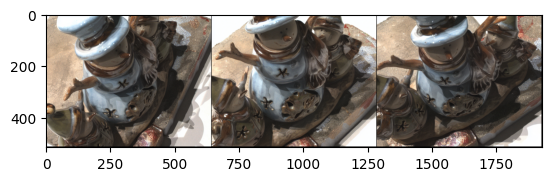

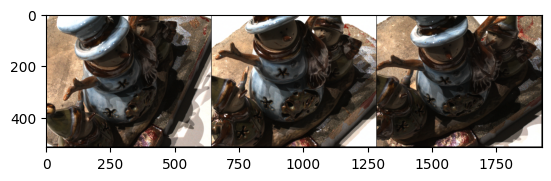

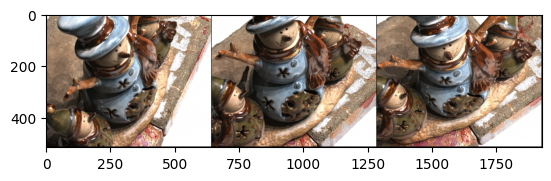

In [19]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt
batch = val_data[0]
save_image(outputs[0].images[0], "output.png")
save_image(batch["images"], "input.png")
save_image(batch["target_imgs"], "target.png")

plt.imshow(plt.imread("output.png"))
plt.show()
plt.imshow(plt.imread("input.png"))
plt.show()
plt.imshow(plt.imread("target.png"))
plt.show()

In [20]:
from pandas import DataFrame
df = DataFrame(val_data.metas,columns=["scan","ref_view","light_idx","src_views","target_light"])    
df.head()                                       

,scan,ref_view,light_idx,src_views,target_light
0,scan3,0,0,"[10, 1, 9, 12, 11, 13, 2, 8, 14, 27]",6
1,scan3,1,0,"[9, 10, 2, 0, 8, 13, 14, 12, 7, 15]",0
2,scan3,2,0,"[8, 1, 7, 9, 3, 15, 14, 16, 6, 10]",5
3,scan3,3,0,"[7, 6, 2, 4, 8, 5, 17, 16, 1, 15]",2
4,scan3,4,0,"[5, 6, 3, 7, 18, 2, 17, 8, 16, 1]",1


In [21]:
df["scan"].unique()

array(['scan3', 'scan5', 'scan17', 'scan21', 'scan28', 'scan35', 'scan37',
       'scan38', 'scan40', 'scan43', 'scan56', 'scan59', 'scan66',
       'scan67', 'scan82', 'scan86', 'scan106', 'scan117'], dtype=object)

In [22]:
from math import sqrt
import sys
sys.path.append('/root/autodl-tmp/project/dp_simple/')
#import ViT
from torchvision import transforms as T
from CasMVSNet_pl.models.mvsnet import CascadeMVSNet
from CasMVSNet_pl.utils import load_ckpt
from CasMVSNet_pl.datasets.dtu import DTUDataset  
from CasMVSNet_pl.utils import *
from CasMVSNet_pl.datasets.dtu import DTUDataset 
from CasMVSNet_pl.metrics import *  
from inplace_abn import ABN

import pytorch_ssim
import pytorch_lightning as pl
import pytorch_ssim
import pytorch_lightning as pl
import sys
sys.path.append('/root/autodl-tmp/D3Dnet/code')

import matplotlib.pyplot as plt

import functools
import torch.nn.functional as F
import torch
from collections import namedtuple
from torchvision import models
import torch.nn as nn
import sys
from einops import rearrange
from torchvision import models
import sys

from CasMVSNet_pl.datasets.utils import save_pfm, read_pfm
import cv2
import torch
import os, shutil
import numpy as np
from tqdm import tqdm
from argparse import ArgumentParser

# for depth prediction
from CasMVSNet_pl.models.mvsnet import CascadeMVSNet
from CasMVSNet_pl.utils import load_ckpt
from inplace_abn import ABN

# for point cloud fusion
from numba import jit
from plyfile import PlyData, PlyElement

torch.backends.cudnn.benchmark = True # this increases inference speed a little

In [23]:
torch.backends.cudnn.benchmark = True # this increases inference speed a little

def get_opts():
    parser = ArgumentParser()
    parser.add_argument('--root_dir', type=str,
                        default='/root/autodl-tmp/mvs_training/dtu',
                        help='root directory of dtu dataset')
    parser.add_argument('--dataset_name', type=str, default='dtu',
                        choices=['dtu', 'tanks', 'blendedmvs'],
                        help='which dataset to train/val')
    parser.add_argument('--split', type=str, default='train',
                        help='which split to evaluate')
    parser.add_argument('--scan', type=str, default='scan7',
                        help='specify scan to evaluate (must be in the split)')
    parser.add_argument('--cpu', default=False, action='store_true',
                        help='''use cpu to do depth inference.
                                WARNING: It is going to be EXTREMELY SLOW!
                                about 37s/view, so in total 30min/scan. 
                             ''')
    # for depth prediction
    parser.add_argument('--n_views', type=int, default=3,
                        help='number of views (including ref) to be used in testing')
    parser.add_argument('--depth_interval', type=float, default=2.65,
                        help='depth interval unit in mm')
    parser.add_argument('--n_depths', nargs='+', type=int, default=[8,32,48],
                        help='number of depths in each level')
    parser.add_argument('--interval_ratios', nargs='+', type=float, default=[1.0,2.0,4.0],
                        help='depth interval ratio to multiply with --depth_interval in each level')
    parser.add_argument('--num_groups', type=int, default=1, choices=[1, 2, 4, 8],
                        help='number of groups in groupwise correlation, must be a divisor of 8')
    parser.add_argument('--img_wh', nargs="+", type=int, default=[640,512],
                        help='resolution (img_w, img_h) of the image, must be multiples of 32')
    parser.add_argument('--ckpt_path', type=str, default='/root/autodl-tmp/project/dp_simple/CasMVSNet_pl/ckpts/_ckpt_epoch_10.ckpt',
                        help='pretrained checkpoint path to load')
    parser.add_argument('--save_visual', default=False, action='store_true',
                        help='save depth and proba visualization or not')

    # for point cloud fusion
    parser.add_argument('--conf', type=float, default=0.999,
                        help='min confidence for pixel to be valid')
    parser.add_argument('--min_geo_consistent', type=int, default=5,
                        help='min number of consistent views for pixel to be valid')
    parser.add_argument('--max_ref_views', type=int, default=400,
                        help='max number of ref views (to limit RAM usage)')
    parser.add_argument('--skip', type=int, default=1,
                        help='''how many points to skip when creating the point cloud.
                                Larger = fewer points and smaller file size.
                                Ref: skip=10 creates ~= 3M points = 50MB file
                                     skip=1 creates ~= 30M points = 500MB file
                             ''')
    args, _ = parser.parse_known_args()
    return args
  
    

In [24]:
def decode_batch(batch):
    imgs = batch['images']
    proj_mats = batch['proj_mats']
    init_depth_min = batch['init_depth_min'].item()
    depth_interval = batch['depth_interval'].item()
    scan, vid = batch['scan_vid']
    return imgs, proj_mats, init_depth_min, depth_interval, \
           scan, vid


# define read_image and read_proj_mat for each dataset

def read_image(dataset_name, root_dir, scan, vid):
    if dataset_name == 'dtu':
        return cv2.imread(os.path.join(root_dir,
                    f'Rectified/{scan}_train/rect_{vid+1:03d}_3_r5000.png'))
    if dataset_name == 'tanks':
        return cv2.imread(os.path.join(root_dir, scan,
                    f'images/{vid:08d}.jpg'))
    if dataset_name == 'blendedmvs':
        return cv2.imread(os.path.join(root_dir, scan,
                    f'blended_images/{vid:08d}.jpg'))


def read_refined_image(dataset_name, scan, vid):
    return cv2.imread(f'results/{dataset_name}/image_refined/{scan}/{vid:08d}.png')


def save_refined_image(image_refined, dataset_name, scan, vid):
    cv2.imwrite(f'results/{dataset_name}/image_refined/{scan}/{vid:08d}.png',
                image_refined)


def read_proj_mat(dataset_name, dataset, scan, vid):
    if dataset_name == 'dtu':
        return dataset.proj_mats[vid][0][0].numpy()
    if dataset_name in ['tanks', 'blendedmvs']:
        return dataset.proj_mats[scan][vid][0][0].numpy()


@jit(nopython=True, fastmath=True)
def xy_ref2src(xy_ref, depth_ref, P_world2ref,
               depth_src, P_world2src, img_wh):
    # create ref grid and project to ref 3d coordinate using depth_ref
    xyz_ref = np.vstack((xy_ref, np.ones_like(xy_ref[:1]))) * depth_ref
    xyz_ref_h = np.vstack((xyz_ref, np.ones_like(xy_ref[:1])))

    P = (P_world2src @ np.ascontiguousarray(np.linalg.inv(P_world2ref)))[:3]
    # project to src 3d coordinate using P_world2ref and P_world2src
    xyz_src_h = P @ xyz_ref_h.reshape(4,-1)
    xy_src = xyz_src_h[:2]/xyz_src_h[2:3]
    xy_src = xy_src.reshape(2, img_wh[1], img_wh[0])

    return xy_src


@jit(nopython=True, fastmath=True)
def xy_src2ref(xy_ref, xy_src, depth_ref, P_world2ref,
               depth_src2ref, P_world2src, img_wh):
    # project xy_src back to ref view using the sampled depth
    xyz_src = np.vstack((xy_src, np.ones_like(xy_src[:1]))) * depth_src2ref
    xyz_src_h = np.vstack((xyz_src, np.ones_like(xy_src[:1])))
    P = (P_world2ref @ np.ascontiguousarray(np.linalg.inv(P_world2src)))[:3]
    xyz_ref_h = P @ xyz_src_h.reshape(4,-1)
    depth_ref_reproj = xyz_ref_h[2].reshape(img_wh[1], img_wh[0])
    xy_ref_reproj = xyz_ref_h[:2]/xyz_ref_h[2:3]
    xy_ref_reproj = xy_ref_reproj.reshape(2, img_wh[1], img_wh[0])

    # check |p_reproj-p_1| < 1
    pixel_diff = xy_ref_reproj - xy_ref
    mask_pixel_reproj = (pixel_diff[0]**2+pixel_diff[1]**2)<1

    # check |d_reproj-d_1| / d_1 < 0.01
    mask_depth_reproj = np.abs((depth_ref_reproj-depth_ref)/depth_ref)<0.01

    mask_geo = mask_pixel_reproj & mask_depth_reproj

    return depth_ref_reproj, mask_geo


def check_geo_consistency(depth_ref, P_world2ref,
                          depth_src, P_world2src,
                          image_ref, image_src,
                          img_wh):
    """
    Check the geometric consistency between ref and src views.
    """
    xy_ref = np.mgrid[:img_wh[1],:img_wh[0]][::-1].astype(np.float32)
    xy_src = xy_ref2src(xy_ref, depth_ref, P_world2ref,
                        depth_src, P_world2src, img_wh)

    # Sample the depth of xy_src using bilinear interpolation
    depth_src2ref = cv2.remap(depth_src,
                              xy_src[0].astype(np.float32),
                              xy_src[1].astype(np.float32),
                              interpolation=cv2.INTER_LINEAR)

    image_src2ref = cv2.remap(image_src,
                              xy_src[0].astype(np.float32),
                              xy_src[1].astype(np.float32),
                              interpolation=cv2.INTER_LINEAR)

    depth_ref_reproj, mask_geo = \
        xy_src2ref(xy_ref, xy_src, depth_ref, P_world2ref, 
                   depth_src2ref, P_world2src, img_wh)

    depth_ref_reproj[~mask_geo] = 0
    image_src2ref[~mask_geo] = 0
    
    return depth_ref_reproj, mask_geo, image_src2ref

In [25]:
def abs_error(depth_pred, depth_gt, mask):
    depth_pred, depth_gt = depth_pred[mask], depth_gt[mask]
    return np.abs(depth_pred - depth_gt)

def acc_threshold(depth_pred, depth_gt, mask, threshold):
    """
    computes the percentage of pixels whose depth error is less than @threshold
    """
    errors = abs_error(depth_pred, depth_gt, mask)
    acc_mask = errors < threshold
    return acc_mask.mean()

def return_log(result1,result2,gt_depth,mask):
    depth_pred = result1["depth_0"][0].cpu().numpy()
    ori_pred = result2["depth_0"][0].cpu().numpy()

    print(depth_pred.shape, ori_pred.shape, gt_depth.shape, mask.shape)
    

    abs_error1 = abs_error(depth_pred, gt_depth, mask).mean()
    abs_error2 = abs_error(ori_pred, gt_depth, mask).mean()
    print(f"depth modified is {abs_error1},original error is {abs_error2} ")
    abs_diff = abs_error1 - abs_error2
    abs_ratio = abs_error1 / abs_error2

    acc1mm1 = acc_threshold(depth_pred, gt_depth, mask, 1)
    acc1mm2 = acc_threshold(ori_pred, gt_depth, mask, 1)
    acc_diff = acc1mm1 - acc1mm2
    acc_ratio = acc1mm1 / (acc1mm2+1e-7)

    acc2mm1 = acc_threshold(depth_pred, gt_depth, mask, 2)
    acc2mm2 = acc_threshold(ori_pred, gt_depth, mask, 2)
    acc_diff2 = acc2mm1 - acc2mm2
    acc_ratio2 = acc2mm1 / (acc2mm2+1e-7)

    acc3mm1 = acc_threshold(depth_pred, gt_depth, mask, 3)
    acc3mm2 = acc_threshold(ori_pred, gt_depth, mask, 3)
    acc_diff3 = acc3mm1 - acc3mm2
    acc_ratio3 = acc3mm1 / (acc3mm2+1e-7)

    acc4mm1 = acc_threshold(depth_pred, gt_depth, mask, 4)
    acc4mm2 = acc_threshold(ori_pred, gt_depth, mask, 4)
    acc_diff4 = acc4mm1 - acc4mm2
    acc_ratio4 = acc4mm1 / (acc4mm2+1e-7)

    return {"abs_diff":abs_diff,"abs_ratio":abs_ratio,"acc_diff1":acc_diff,"acc_ratio1":acc_ratio,
            "acc_diff2":acc_diff2,"acc_ratio2":acc_ratio2,"acc_diff3":acc_diff3,"acc_ratio3":acc_ratio3,
            "acc_diff4":acc_diff4,"acc_ratio4":acc_ratio4}



In [26]:
args = get_opts()

In [27]:
model = CascadeMVSNet(n_depths=args.n_depths,
                        interval_ratios=args.interval_ratios,
                        num_groups=args.num_groups,
                        norm_act=ABN)
device = 'cpu' if args.cpu else 'cuda:0'
model.to(device)
load_ckpt(model, args.ckpt_path)
model.eval()


CascadeMVSNet(
  (feature): FeatureNet(
    (conv0): Sequential(
      (0): ConvBnReLU(
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): ABN(8, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
      (1): ConvBnReLU(
        (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): ABN(8, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
    )
    (conv1): Sequential(
      (0): ConvBnReLU(
        (conv): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (bn): ABN(16, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
      (1): ConvBnReLU(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): ABN(16, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
      (2): ConvBnReLU(
        (conv): Conv2d(16, 16, k

In [28]:
refine = True
read_gt = False

In [29]:
val_data[0]["depths"]["level_0"].shape

torch.Size([512, 640])

In [30]:
transform = T.Compose([T.Normalize(mean=[0.485, 0.456, 0.406], 
std=[0.229, 0.224, 0.225])])

In [38]:

print('Creating depth and confidence predictions...')
for scan in ["scan106"]:
    depth_dir = f'./results/{args.dataset_name}/depth'
    depth_dir = os.path.join(depth_dir, scan)

    img_dir = f'./results/{args.dataset_name}/image_modified'
    img_dir = os.path.join(img_dir, scan)

    os.makedirs(depth_dir, exist_ok=True)
    os.makedirs(img_dir, exist_ok=True)

    abs_ratio = []
    acc_ratio1 = []
    acc_ratio2 = []
    acc_ratio3 = []
    acc_ratio4 = []
    acc_diff1 = []
    acc_diff2 = []
    acc_diff3 = []
    acc_diff4 = []
    abs_diff = []

    data_range = [i for i, x in enumerate(val_data.metas) if x[0] == scan]
    print(f'Processing {scan} with {len(data_range)} views')
    for i in tqdm(data_range):
        batch =  val_data[i]
        batch["images"][batch["images"]<0.2]*=0
        imgs, proj_mats, init_depth_min, depth_interval, \
            scan, vid = decode_batch(batch)
        proj_mats = proj_mats.unsqueeze(0).to("cuda")
       
        
        
        
        os.makedirs(os.path.join(depth_dir, scan), exist_ok=True)

        with torch.no_grad():
            imgs = imgs.unsqueeze(0).to(device)
           
            
            
            if refine == True:
                modified_imgs = process_batch(pipeline,batch)[0].images
                results_modified = model(transform(modified_imgs), proj_mats, init_depth_min, depth_interval)
                imgs_original = imgs[0]
                pred_imgs = modified_imgs[0]
                torch.stack([imgs_original, pred_imgs], dim=0)
                save_image(torch.cat([imgs_original, pred_imgs], dim=0), 
                           os.path.join(img_dir, f'{vid:04d}_class6.png'))
                np.save(os.path.join(img_dir, f'{vid:04d}_class6.npy'), pred_imgs.cpu().numpy())
            
            results_ori = model(transform(imgs), proj_mats, init_depth_min, depth_interval)

            metric_logs = return_log(results_modified,
                                     results_ori,
                                     val_data[i]["depths"]["level_0"].numpy(),
                                     val_data[i]["masks"]["level_0"].numpy())
            abs_ratio.append(metric_logs["abs_ratio"])
            acc_ratio1.append(metric_logs["acc_ratio1"])
            acc_ratio2.append(metric_logs["acc_ratio2"])
            acc_ratio3.append(metric_logs["acc_ratio3"])
            acc_ratio4.append(metric_logs["acc_ratio4"])
            acc_diff1.append(metric_logs["acc_diff1"])
            acc_diff2.append(metric_logs["acc_diff2"])
            acc_diff3.append(metric_logs["acc_diff3"])
            acc_diff4.append(metric_logs["acc_diff4"])
            abs_diff.append(metric_logs["abs_diff"])

            # print output
            sys.stdout.write(f'\r{scan} {vid:04d} '
                            f'abs_diff: {np.mean(abs_diff)} '
                            f'abs_ratio: {np.mean(abs_ratio)} '
                            f'acc_diff1: {np.mean(acc_diff1)} '
                            f'acc_ratio1: {np.mean(acc_ratio1)} '
                            f'acc_diff2: {np.mean(acc_diff2)} '
                            f'acc_ratio2: {np.mean(acc_ratio2)} '
                            f'acc_diff3: {np.mean(acc_diff3)} '
                            f'acc_ratio3: {np.mean(acc_ratio3)} '
                            f'acc_diff4: {np.mean(acc_diff4)} '
                            f'acc_ratio4: {np.mean(acc_ratio4)} ')
            
            sys.stdout.flush()

            
        
        depth = results_ori['depth_0'][0].cpu().numpy()
        depth = np.nan_to_num(depth) # change nan to 0
        proba = results_ori['confidence_2'][0].cpu().numpy() # NOTE: this is 1/4 scale!
        proba = np.nan_to_num(proba) # change nan to 0
        save_pfm(os.path.join(depth_dir, f'{scan}/depth_{vid:04d}.pfm'), depth)
        save_pfm(os.path.join(depth_dir, f'{scan}/proba_{vid:04d}.pfm'), proba)
        if args.save_visual:
            mi = np.min(depth[depth>0])
            ma = np.max(depth)
            depth = (depth-mi)/(ma-mi+1e-8)
            depth = (255*depth).astype(np.uint8)
            depth_img = cv2.applyColorMap(depth, cv2.COLORMAP_JET)
            cv2.imwrite(os.path.join(depth_dir, f'{scan}/depth_visual_{vid:04d}.jpg'),
                        depth_img)
            cv2.imwrite(os.path.join(depth_dir, f'{scan}/proba_visual_{vid:04d}.jpg'),
                        (255*(proba>args.conf)).astype(np.uint8))
        del imgs, proj_mats, results_ori, results_modified
    
    torch.cuda.empty_cache()

Creating depth and confidence predictions...
Processing scan106 with 49 views


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 16,image_guidance: 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 59.45664596557617,original error is 86.24919891357422 
scan106 0000 abs_diff: -26.792552947998047 abs_ratio: 0.6893588304519653 acc_diff1: -0.15545554345895077 acc_ratio1: 0.4862943013928293 acc_diff2: -0.11232684520040634 acc_ratio2: 0.6795782775187249 acc_diff3: -0.07712876203144003 acc_ratio3: 0.790125843232227 acc_diff4: -0.05704485512164681 acc_ratio4: 0.8491293459327556 

  2%|▏         | 1/49 [00:54<43:49, 54.78s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 16,image_guidance: 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

(512, 640) (512, 640) (512, 640) (512, 640)
depth modified is 43.303672790527344,original error is 83.46034240722656 
scan106 0001 abs_diff: -33.474609375 abs_ratio: 0.604106068611145 acc_diff1: -0.1334898993348511 acc_ratio1: 0.537697450891855 acc_diff2: -0.08300500671793963 acc_ratio2: 0.7561954989938282 acc_diff3: -0.047344492030506946 acc_ratio3: 0.8694386674867732 acc_diff4: -0.02567310281175708 acc_ratio4: 0.9325270092005781 

  4%|▍         | 2/49 [01:49<43:02, 54.94s/it]

torch.Size([3, 3, 512, 640])
conduct do_classifier_free_guidance, text_guidance: 16,image_guidance: 1.0


  0%|          | 0/50 [00:00<?, ?it/s]